In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))])

In [3]:
trainset = torchvision.datasets.MNIST(root='./data',
                                    train=True,
                                    download=True,
                                    transform=transform)

testset = torchvision.datasets.MNIST(root='./data',
                                    train=False,
                                    download=True,
                                    transform=transform)

In [4]:
train_loader = DataLoader(trainset,
                         batch_size=128,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(testset,
                         batch_size=128,
                          shuffle=False,
                          num_workers=2)

In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

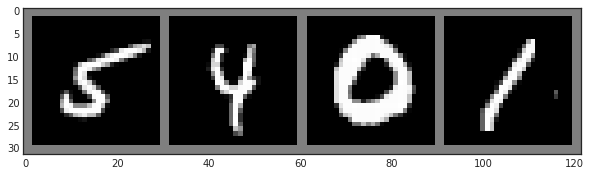

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))

### 모델 구성 및 학습

In [7]:
# 전체 모델 아키텍처

class Net(nn.Module):
    def __init__(self): # layer 정의
        super(Net, self).__init__()

        # input size = 28x28 
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print("Epoch: {}, Iter: {}, Loss: {}".format(epoch+1, i+1, running_loss/(100*(i/100))))

Epoch: 1, Iter: 100, Loss: 2.325159764049029
Epoch: 1, Iter: 200, Loss: 2.311566543339485
Epoch: 1, Iter: 300, Loss: 2.30487529330429
Epoch: 1, Iter: 400, Loss: 2.2997531072238933
Epoch: 2, Iter: 100, Loss: 2.282765364406085
Epoch: 2, Iter: 200, Loss: 2.254887434705418
Epoch: 2, Iter: 300, Loss: 2.222110464421403
Epoch: 2, Iter: 400, Loss: 2.15686947928933


In [10]:
# pretrained 모델 정확도 계산
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        im, la = data
        outputs = net(im)
        _, predicted = torch.max(outputs.data, 1)
        total += la.size(0)
        correct += (predicted == la).sum().item()
    
    print(100 * correct / total)

71.34


### Pre-trained 모델 저장

In [11]:
PATH = '/home/proj01/jungha/mnist_net.pth'
torch.save(net.state_dict(), PATH)

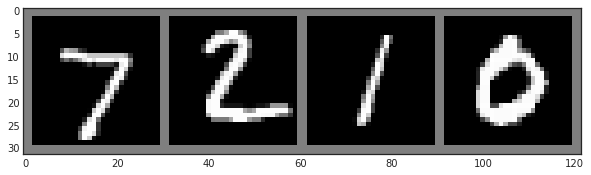

In [12]:
dataiter_test = iter(test_loader) # test data
images_test, labels_test = dataiter_test.next()
imshow(torchvision.utils.make_grid(images_test[:4]))

In [13]:
input_image = images_test
output_data = F.max_pool2d(F.relu(net.conv2(F.max_pool2d(F.relu(net.conv1(input_image)), (2, 2)))), 2)
output = output_data.data

In [14]:
output_data

tensor([[[[2.1171e-01, 9.5223e-02, 8.1413e-02, 8.1413e-02, 8.1413e-02],
          [8.2812e-02, 3.4671e-01, 3.1746e-01, 3.5943e-01, 5.7709e-01],
          [8.1413e-02, 8.1413e-02, 2.8004e-01, 2.1762e-01, 6.5410e-01],
          [8.1413e-02, 8.3272e-02, 3.7894e-01, 1.6244e-01, 6.5996e-01],
          [8.1413e-02, 2.4989e-01, 0.0000e+00, 6.5936e-01, 4.4058e-01]],

         [[1.0098e+00, 1.0185e+00, 1.0098e+00, 1.0098e+00, 1.0098e+00],
          [5.1676e-01, 1.4432e+00, 1.1659e+00, 6.0154e-01, 2.3583e+00],
          [1.1485e+00, 1.9082e+00, 2.0320e+00, 9.4328e-01, 3.2449e+00],
          [1.0098e+00, 1.0098e+00, 8.6290e-01, 3.1739e+00, 3.5835e+00],
          [1.0098e+00, 1.0098e+00, 9.5147e-01, 3.6073e+00, 1.5451e+00]],

         [[5.5010e-01, 7.7764e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.7542e+00, 3.3823e+00, 2.8833e+00, 2.7391e+00, 2.8074e+00],
          [2.5561e-01, 2.5258e-01, 1.3262e-01, 2.7349e+00, 2.1558e+00],
          [0.0000e+00, 0.0000e+00, 1.8197e+00, 2.7232e+00, 6

In [15]:
output_arr = output.numpy()
output_arr.shape

# batch, filter, 5*5 

(128, 16, 5, 5)

In [16]:
torch_image = torch.squeeze(images[0])
print(torch_image.shape)

image_ = torch_image.numpy()

torch.Size([28, 28])


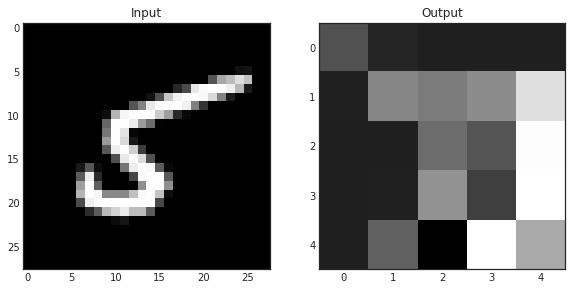

In [17]:
plt.figure(figsize=(15,30))
plt.subplot(131)
plt.title("Input")
plt.imshow(image_, 'gray')
plt.subplot(132)
plt.title("Output")
plt.imshow(output_arr[0,0,:,:], 'gray')
plt.show()

### 저장한 extracted feature output값 불러오기

In [18]:
np.save('./frozen_output/test.npy', output_data.data)
frozen_output = np.load('./frozen_output/test.npy')
mid_output = torch.Tensor(frozen_output)

### fully connected layer 모델 선언 및 weight load

In [19]:
class TF_NET(nn.Module):
    def __init__(self):
        super(TF_NET, self).__init__()
         
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
trainable_model = TF_NET()

In [20]:
state_dict = torch.load(PATH)

with torch.no_grad():
    trainable_model.fc1.weight.copy_(state_dict['fc1.weight'])
    trainable_model.fc1.bias.copy_(state_dict['fc1.bias'])
    trainable_model.fc2.weight.copy_(state_dict['fc2.weight'])
    trainable_model.fc2.bias.copy_(state_dict['fc2.bias'])
    trainable_model.fc3.weight.copy_(state_dict['fc3.weight'])
    trainable_model.fc3.bias.copy_(state_dict['fc3.bias'])

### 71.34%의 동일한 분류 정확도 산출

In [21]:
# 중간 결과 값 받아와서 trainable model에 넣어서 정확도 계산.
# 주석처리 한 부분은 파일로 따로 저장하고, 다시 load해서 할려고 했는데 shape에 문제가 있는거같아서 일단 둠 
correct = 0
total = 0

with torch.no_grad():
    for epoch in range(2):
        running_loss = 0.0
        for i, data in enumerate(test_loader, 0):
            images_test, labels_test = data
            output_data = F.max_pool2d(F.relu(net.conv2(F.max_pool2d(F.relu(net.conv1(images_test)), (2, 2)))), 2)
            outputs = trainable_model(output_data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels_test.size(0)
            correct += (predicted == labels_test).sum().item()
            
    print(100 * correct / total)

71.34
